In [1]:
from pathlib import Path
from math import sqrt

from fitter import Fitter, get_common_distributions
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression

from source.KNN import KNN, euclidean_distance
from source.PNN import PNN
from source.metrics import accuracy_score, plot_confusion_matrix, print_summary
from source.plot import plot_kde, plot_histrogram, plot_importance, plot_pairplot, plot_correlation, plot_pca
from source.fuzzy import trapezeL, trapezeR, triangle, tNorm, sNorm

pd.options.display.float_format = '{:.3f}'.format
pd.options.mode.chained_assignment = None

# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////


 #### Wczytywanie danych

 W pracy został wykorzystany zbiór danych dotyczący sprawności fizycznej.
 Znajduje się w domenie publicznej i jest dostępny na [kaggle.com][1]

 W zbiorze znajduje się ponad 13 tys. rekordów. Każda próbka ma dwanaście cech.
 * age (wiek)
 * gender (płeć)
 * height_cm (wzrost)
 * weight_kg (waga)
 * body fat_% (procent tkanki tłuszczowej)
 * diastolic (rozkurczowe ciśnienie krwi)
 * systolic (skurczowe ciśnienie krwi)
 * gripForce (siła chwytu)
 * sit and bend forward_cm (skłon do przodu w pozycji siedzącej)
 * sit-ups counts (ilość przysiadów)
 * broad jump_cm (skok w dal)
 * class (klasa)

 [1]: https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [2]:
pure = pd.read_csv(Path('./source/data/bodyPerformance.csv'))
pure.dropna(inplace=True)
pure.reset_index(inplace=True, drop=True)

x = pure.loc[:, pure.columns != "gender"]
y = pure.loc[:, "gender"]
name = pure.iloc[:, 0].name

for col in x:
  if x[col].dtype == 'object':
    m = {old_v: new_v for new_v, old_v in enumerate(x[col].unique())}
    x[col] = x[col].map(m)

x.columns = [name.replace(' ', '_') for name in x.columns]
y.name = y.name.replace(' ', '_')

# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////
# /////////////////////////////////////////////////////////////////////////////


 #### Wizualizacja danych

 plot_pairplot pozwala na wizualizację pomiędzy parami cech z podziałem ze
 względu na płeć(niebieski - mężczyzna, pomarańczowy - kobieta). Na przekątnej
 znajdują się wykresy skrzypcowe dla każdej cechy. Górnotrójkątna część
 przedstawia wykres punktowy z regresją liniową, a dolnotrójkątna wykres
 punktowy z estymatorem jądrowym gęstości.

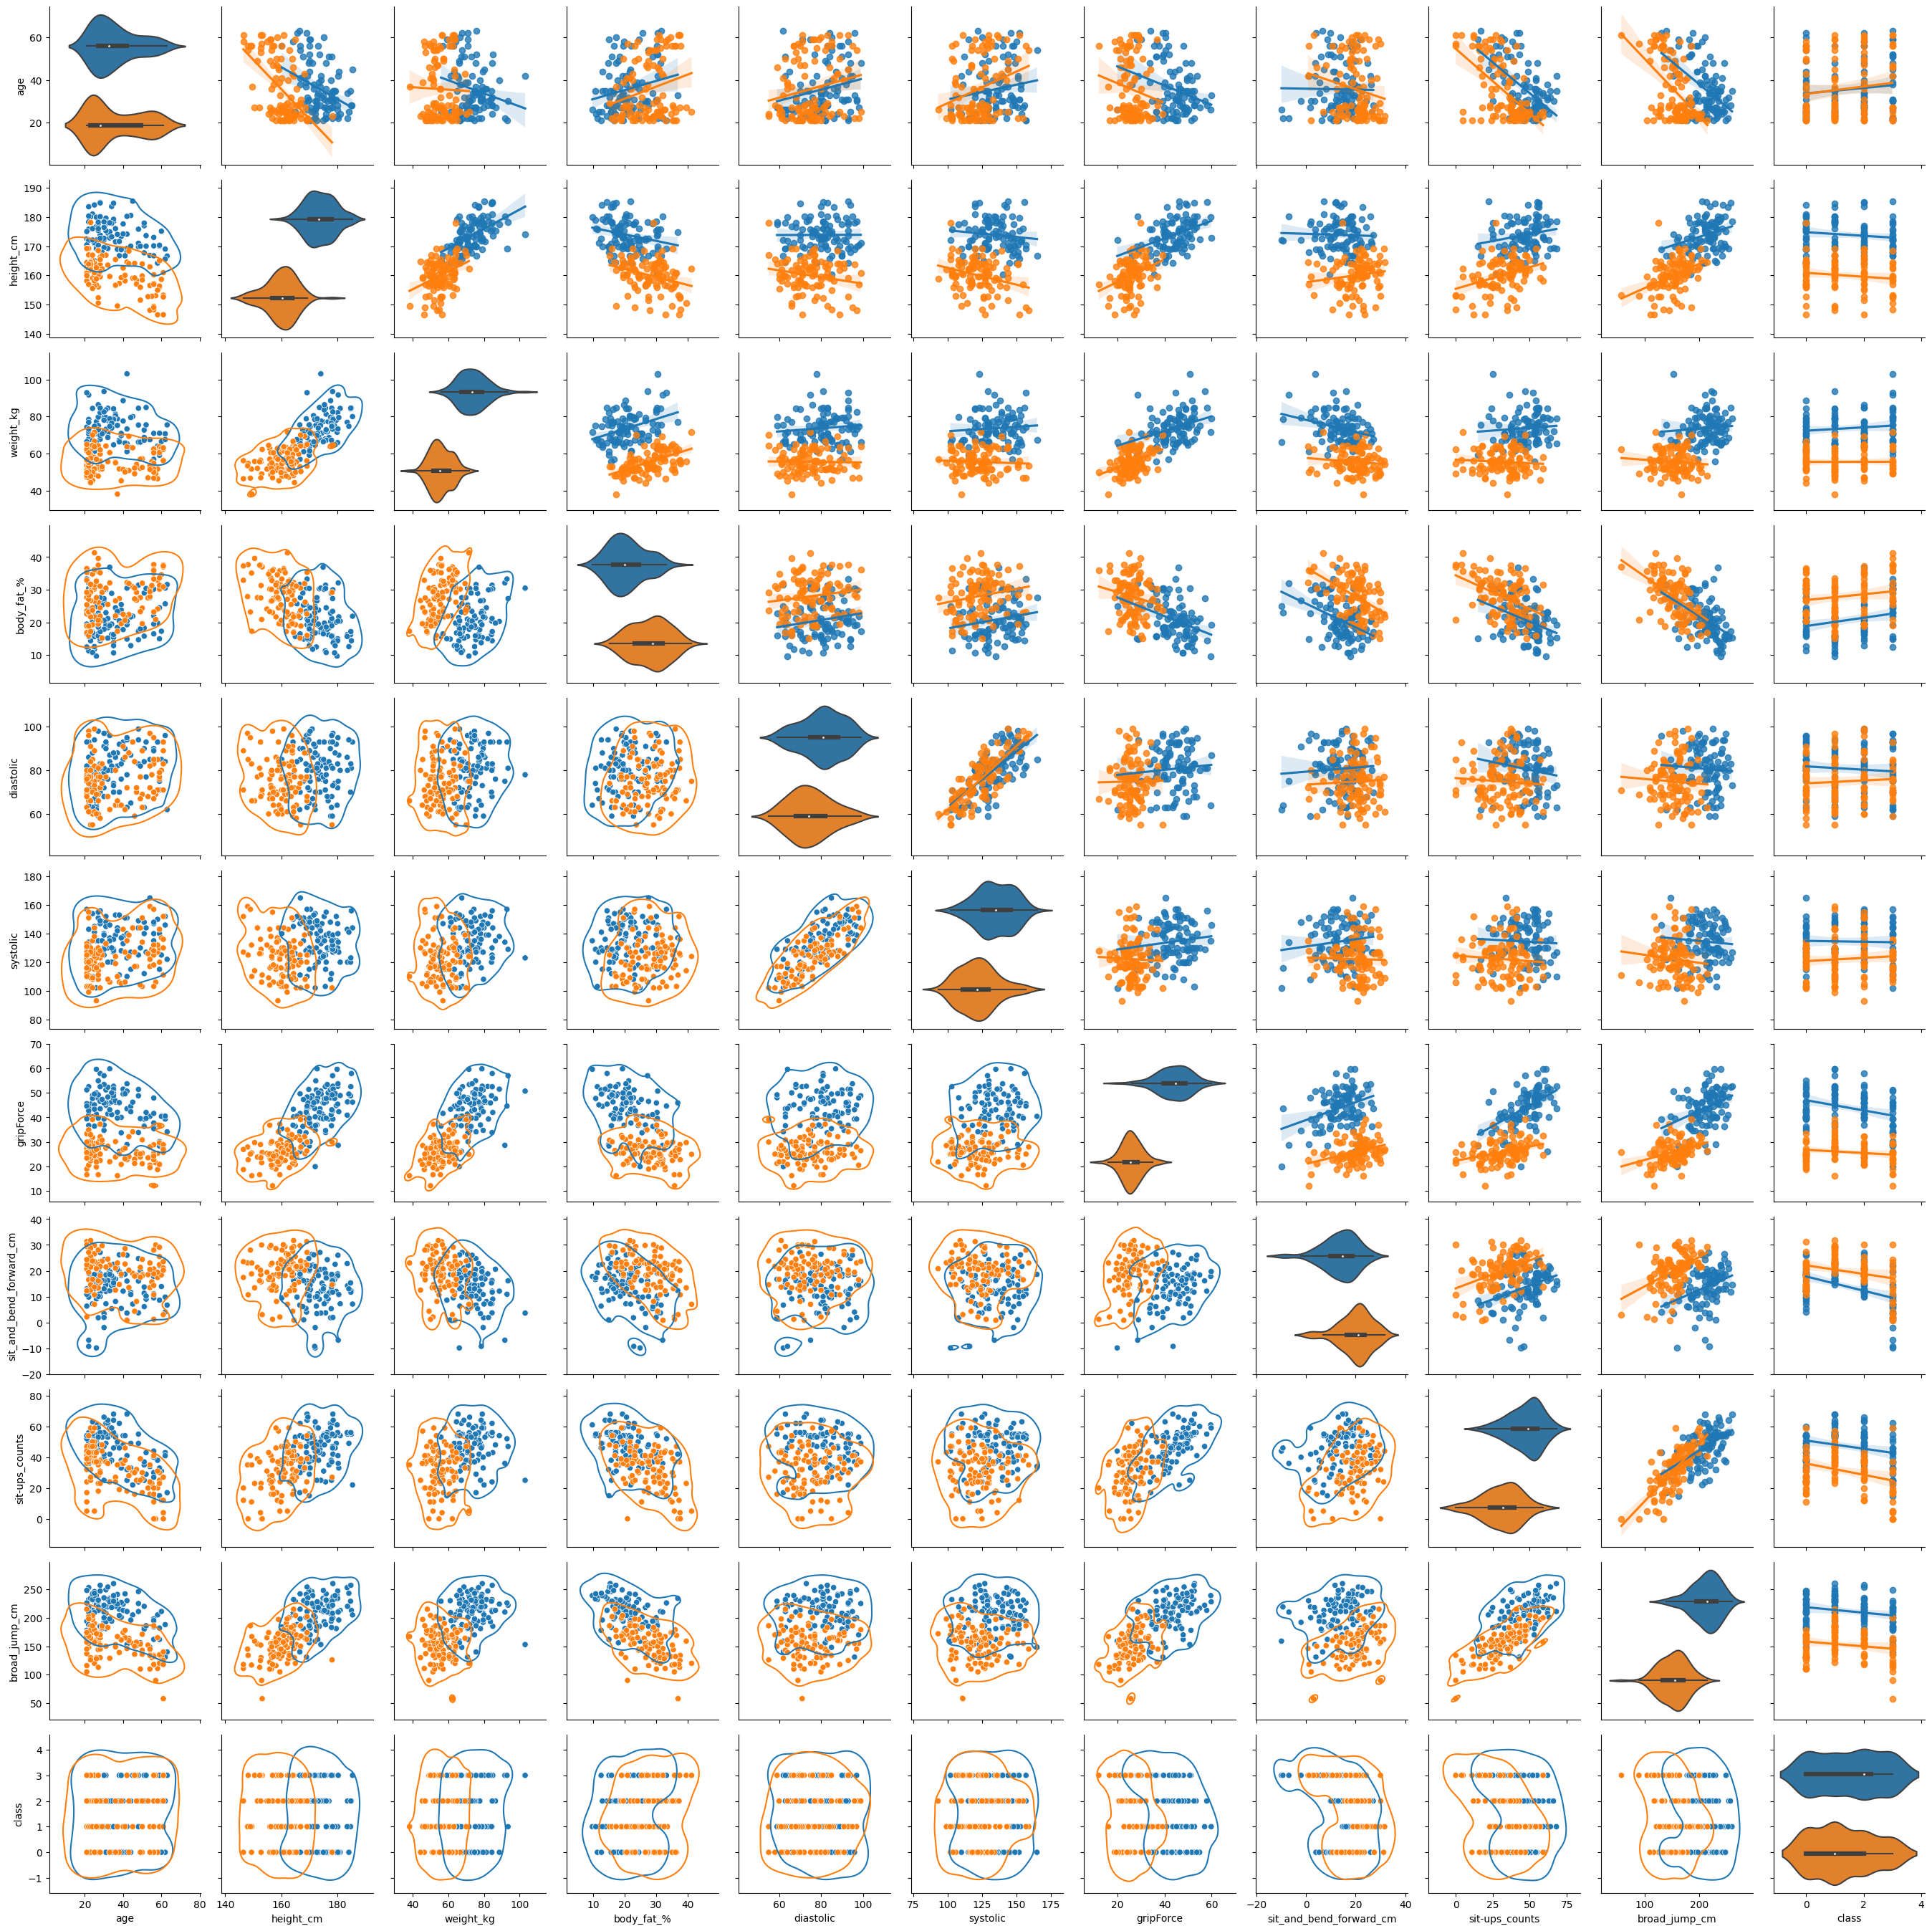

In [3]:
plot_pairplot(x, y)


 plot_correlation zwraca współczynniki korelacji Pearsona oznaczające poziom
 zależności liniowej między zmiennymi. 1 oznacza dodatnią liniową zależność,
 -1 ujemną liniową zależność, a 0 brak liniowej zależność.

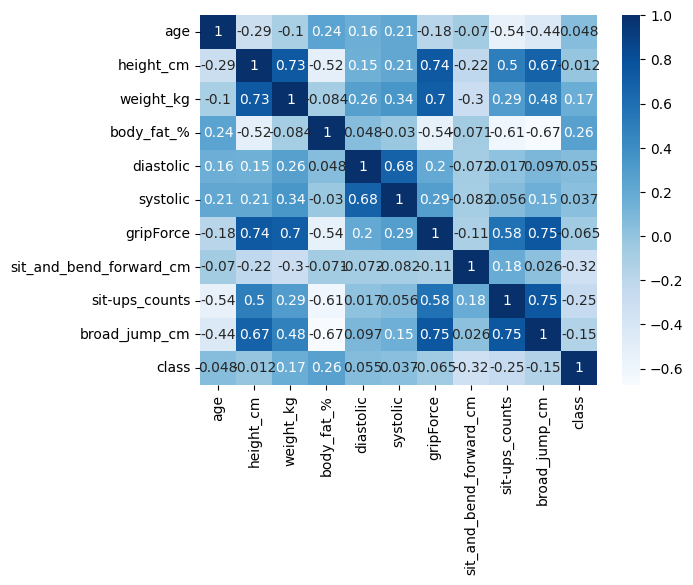

In [4]:
plot_correlation(x, y)


 Aby zmniejszyć ilość cech możemy użyć analizy głównych składowych. plot_pca
 rysuje wykres przedstawiający procent wyjaśnionej wariancji względem ilości
 komponentów.

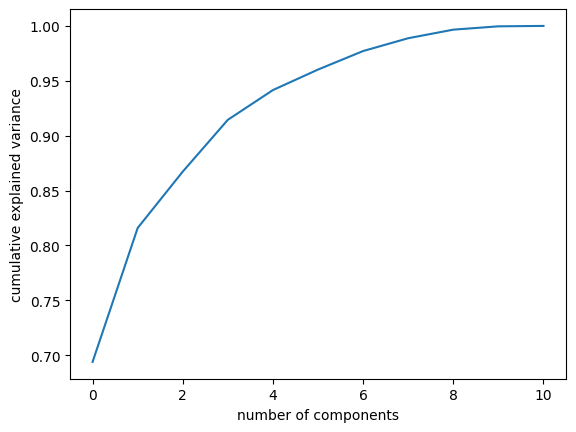

In [5]:
plot_pca(x)


 Histogram pokazuje nam, ile obserwacji przypada na określony przedział
 wartości.

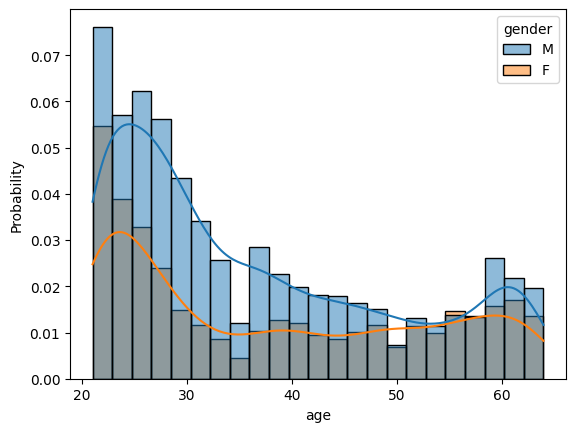

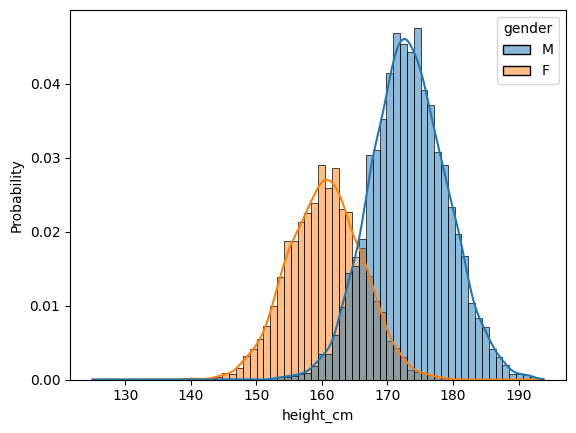

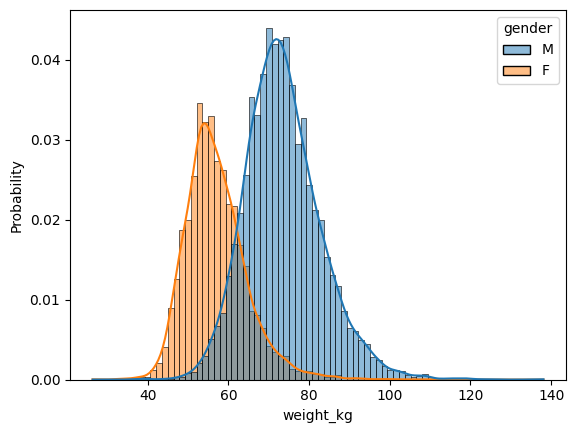

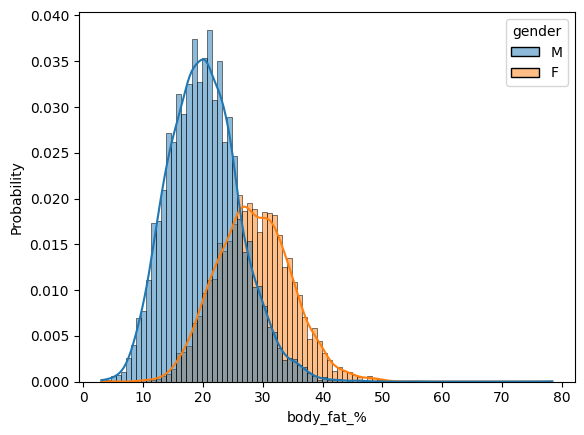

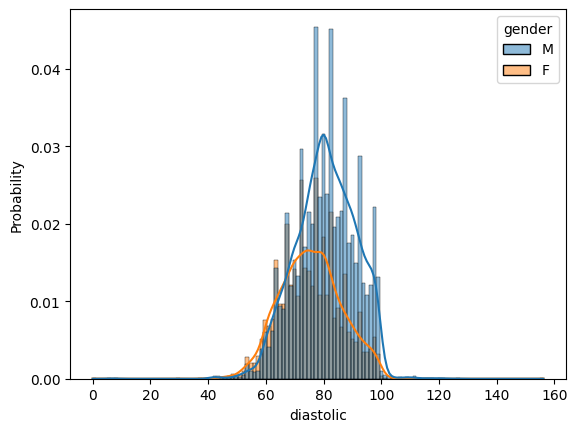

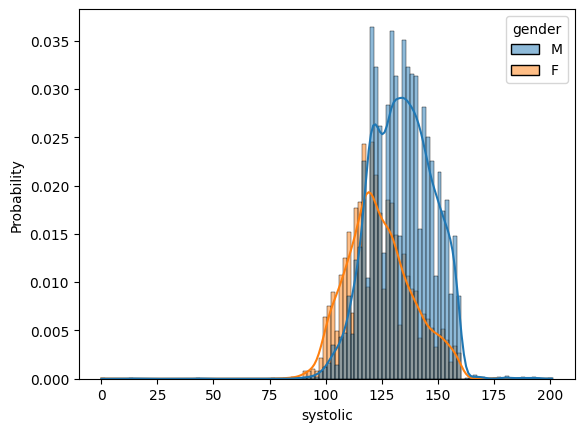

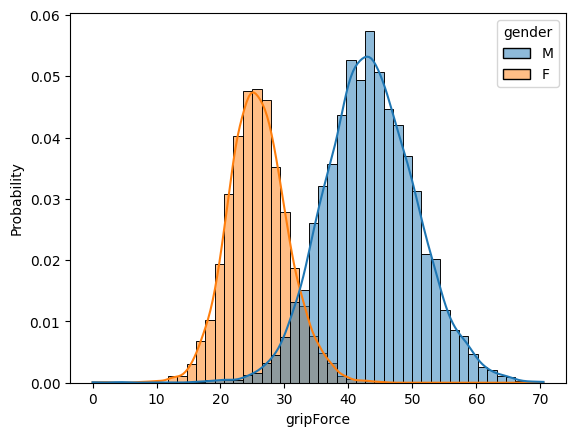

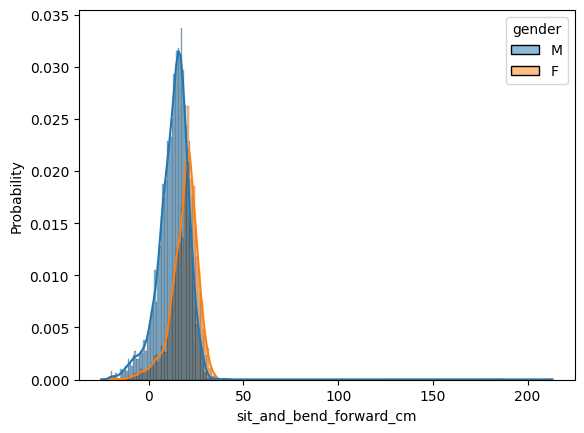

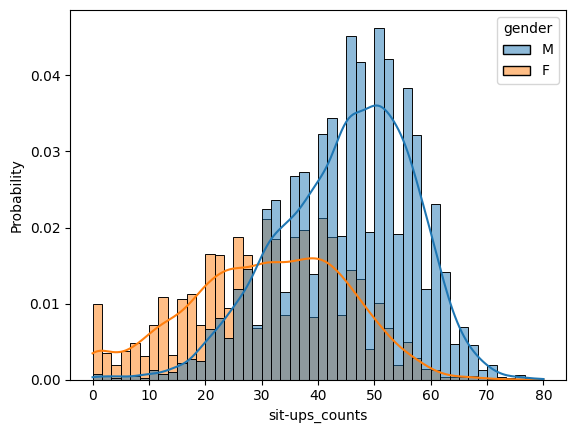

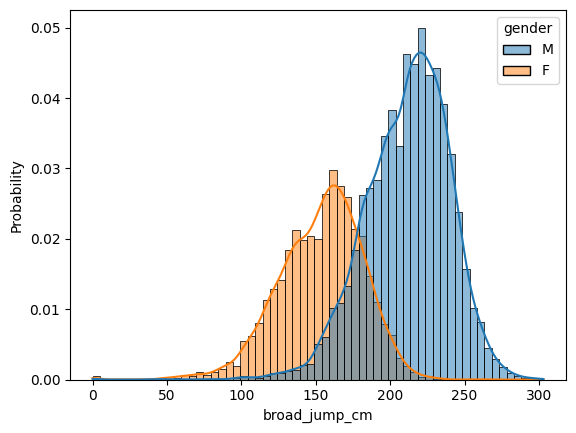

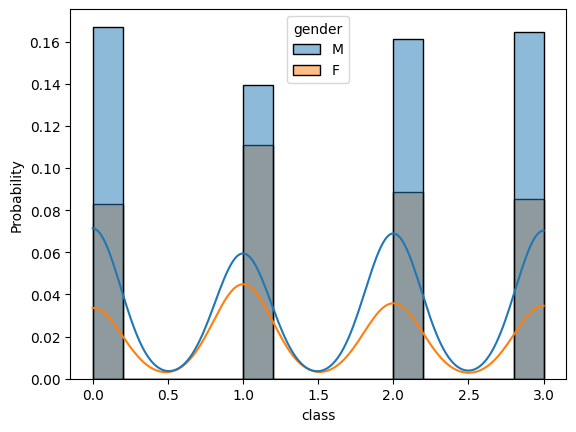

In [6]:
plot_histrogram(x, y)


 Estymator jądrowy gęstości (ang. kernel density estimate, kde) to metoda
 wizualizacji rozkładu obserwacji w zbiorze danych, analogiczna do histogramu.

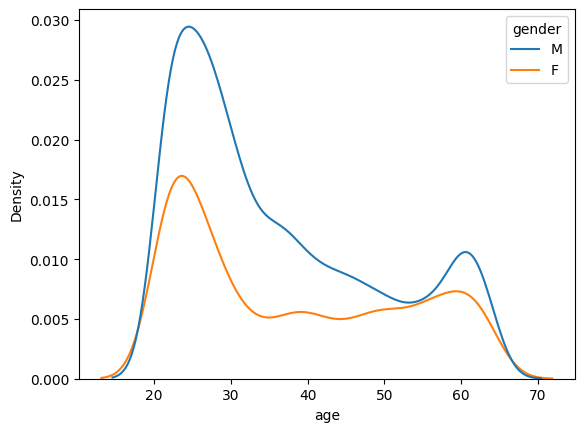

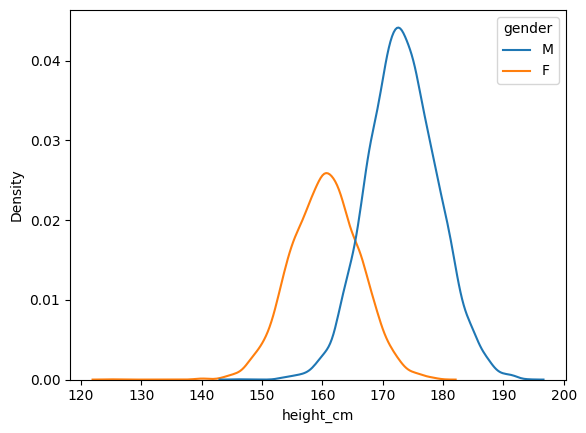

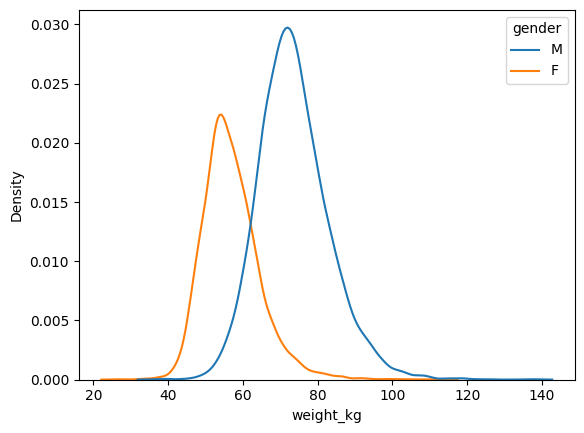

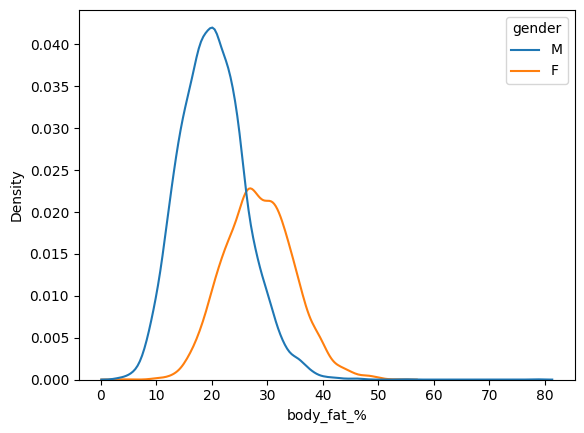

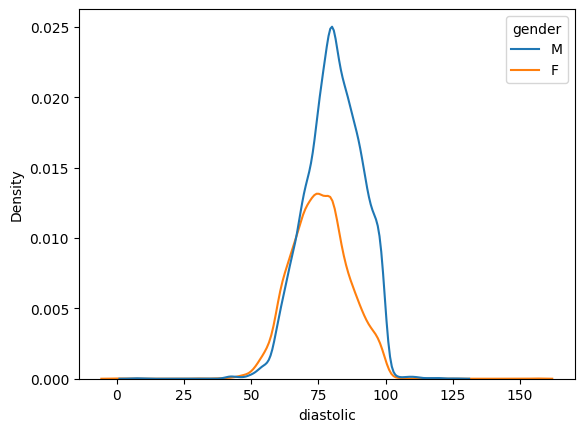

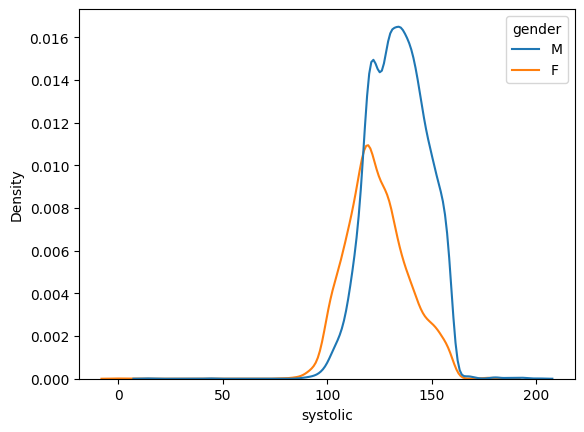

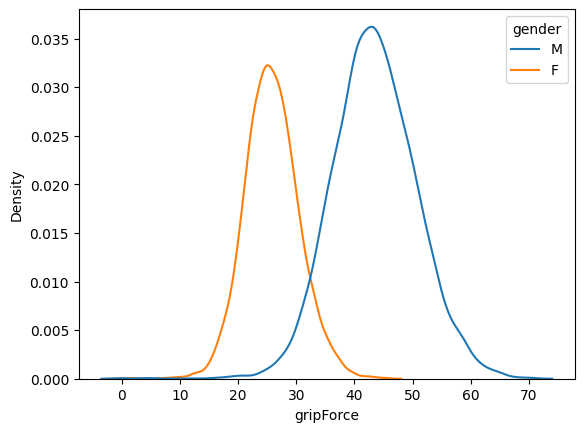

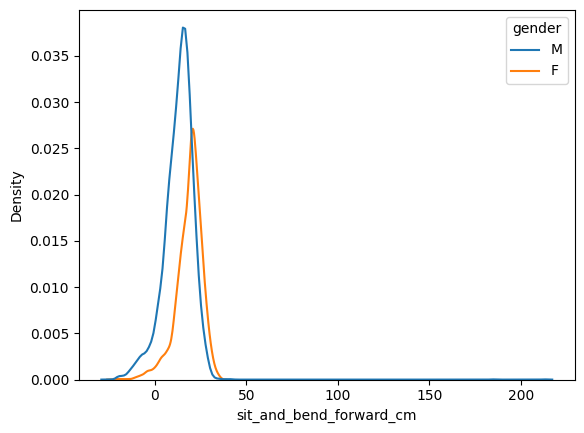

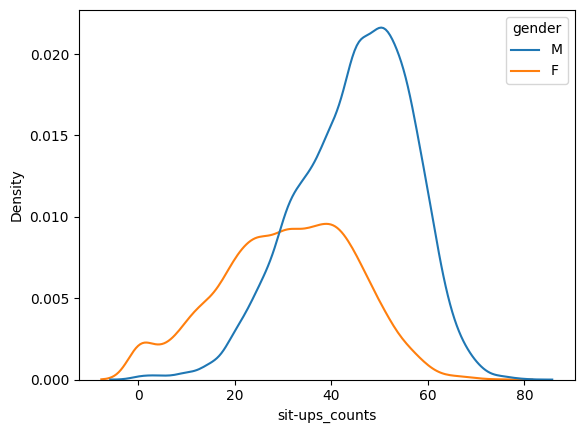

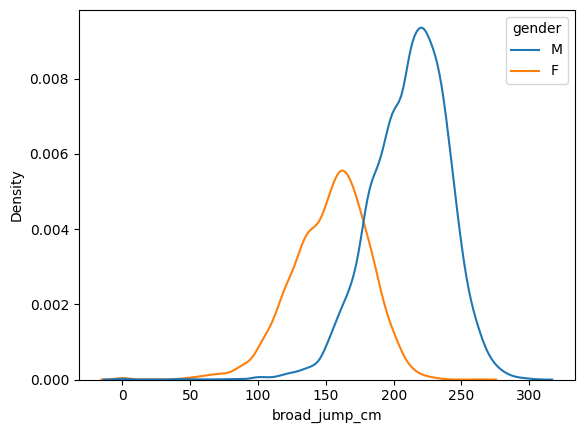

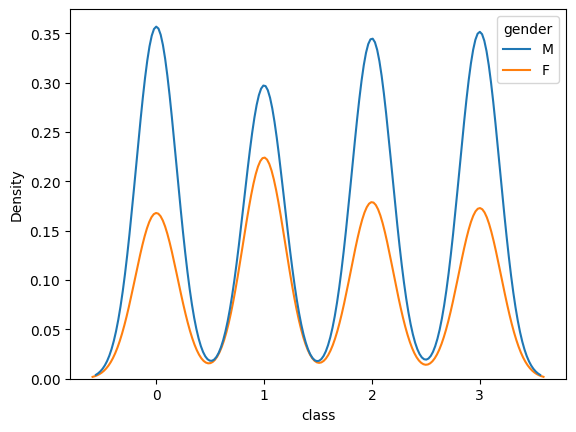

In [7]:
plot_kde(x, y)


 Wykres pudełkowy przedstawia położenie, rozproszenie i kształt rozkładu
 empirycznego badanej cechy.

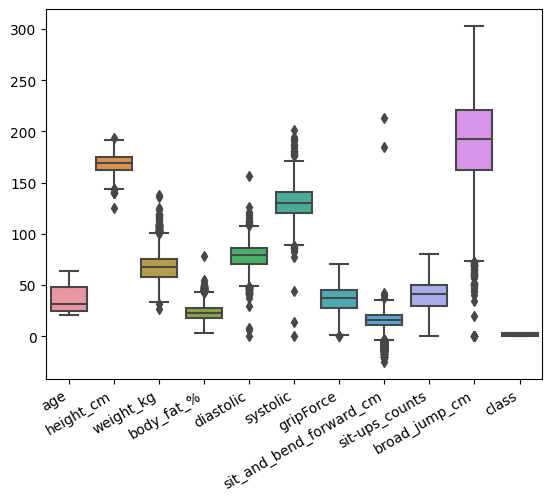

In [8]:
ax = sns.boxplot(data=x)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()


 Wykres pudełkowy ale z podziałem ze względu na płeć.

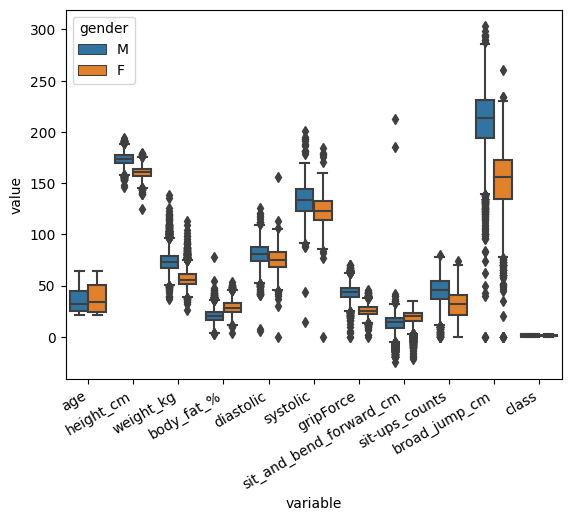

In [9]:
df = pd.melt(pd.concat([x, y], axis=1), id_vars=[y.name])
ax = sns.boxplot(data=df, x='variable', y='value', hue=y.name)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Usuwanie wartości odstających

 Obserwacje odstające są odległe od pozostałych elementów próby. Mogą być wynikiem
 błędnego pomiaru lub odzwierciedlać rzeczywisty przypadek, ale taki, który jest
 mało prawdopodobny. Takie obserwacje chcemy usuwać bo mogą negatywnie wpływać
 na jakość modelu. Poniżej znajdują się dwa algorytmy, którymi możemy je usunąć.

 Drugi algorytm wykorzystuje odchylenie standardowe. Jeżeli obserwacja znajduje się
 poza przedziałem [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR], gdzie Q1 i Q3 to odpowiednio
 pierwszy i trzeci kwartyl, a IQR to rozstęp kwartylny, to taką obserwację zaliczamy
 jako odstającą.

In [ ]:
clf = IsolationForest(n_estimators=round(y.size/10))
pred = clf.fit_predict(x)

mask = [True if x == -1 else False for x in pred]
to_remove = x.loc[mask, name]

print(to_remove)

x.drop(to_remove.index, inplace=True)
y.drop(to_remove.index, inplace=True)
x.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)


In [10]:
removed_elements = pd.Series(dtype='float')

for col in x:
  outliers = boxplot_stats(x.loc[:, col])[0]['fliers']
  mask = x.loc[:, col].isin(outliers)
  to_remove = x.loc[mask, :]
  
  removed_elements = pd.concat([to_remove, removed_elements], axis=0)

  x.drop(to_remove.index, inplace=True)
  y.drop(to_remove.index, inplace=True)
  x.reset_index(inplace=True, drop=True)
  y.reset_index(inplace=True, drop=True)

print(removed_elements)

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


         age  height_cm  weight_kg  body_fat_%  diastolic  systolic  \
458   22.000    167.400     66.200      34.000     62.000   110.000   
480   63.000    156.900     55.900      31.300     88.000   160.000   
1058  64.000    157.000     56.700      30.300     54.000   120.000   
1718  34.000    147.800     46.500      30.700     58.000   114.000   
2307  50.000    166.700     62.600      31.000     61.000   101.000   
...      ...        ...        ...         ...        ...       ...   
6057  28.000    139.900     52.200      44.800     79.000   132.000   
6882  56.000    139.500     44.800      32.300     81.000   133.000   
8251  56.000    125.000     34.400      39.200     69.000   125.000   
11237 64.000    140.500     49.600      32.100     71.000   116.000   
12366 59.000    143.700     54.600      36.600     81.000   156.000   

       gripForce  sit_and_bend_forward_cm  sit-ups_counts  broad_jump_cm  \
458       28.500                   11.200          38.000          0.00

 #### Normalizacja i standaryzacja

 Niektóre algorytmy wymagają, aby dane zostały podjęte normalizacji lub
 standaryzacji. Normalizacja polega na przeskalowaniu danych zazwyczaj
 do wartości od 0 do 1. Standaryzacja przekształca rozkład do
 standardowego rozkładu normalnego czyli o wartości średniej 0 oraz odchyleniu
 standardowym 1.

In [11]:
normalizer = preprocessing.MinMaxScaler().fit(x)
x = pd.DataFrame(normalizer.transform(x), columns=x.columns)


In [ ]:
normalizer = preprocessing.StandardScaler().fit(x)
x = pd.DataFrame(normalizer.transform(x), columns=x.columns)

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Analizy głównych składowych

 Za pomocą analizy głównych składowych jesteśmy w stanie przekształcić układ
 współrzędnych w taki sposób, aby zmaksymalizować wariancję.

 Algorytm poniżej dobierze minimalną ilość komponentów, która jest potrzebna
 do wyjaśnienia 95% wariancji.

In [ ]:
explained_variance = 0.95

pca = PCA()
pca.fit(x)

total_sum = np.cumsum(pca.explained_variance_ratio_)
coponents = np.argmax(total_sum >= explained_variance) + 1

pca = PCA(n_components=coponents)
principalComponents = pca.fit_transform(x)

x = pd.DataFrame(data = principalComponents, columns=[f"PCA{i}" for i in range(coponents)])

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Klasyfikacja za pomocą KNN

 KNN klasyfikuje nowe próbki biorąc pod uwagę k najbliższych sąsiadów.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [ ]:
y_pred = KNN(x_train, y_train, 3, x_test, euclidean_distance)
plot_confusion_matrix(y_test, y_pred)
print_summary(y_test, y_pred)


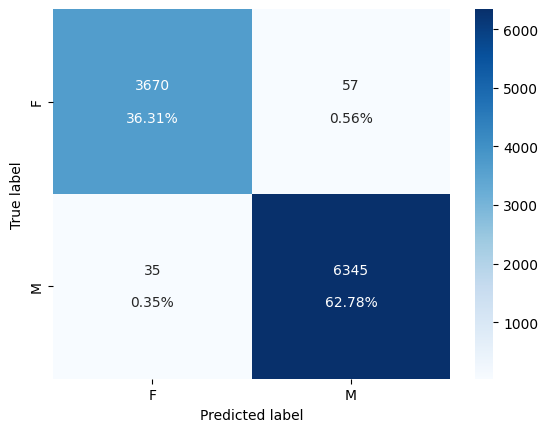

            accuracy precision sensitivity specificity f1-score  support
F              0.991     0.991       0.985       0.995    0.988 3727.000
M              0.991     0.991       0.995       0.985    0.993 6380.000
                                                                        
accuracy       0.991                                                    
precision      0.991                                                    
sensitivity    0.985                                                    
specificity    0.995                                                    
fscore         0.988                                                    


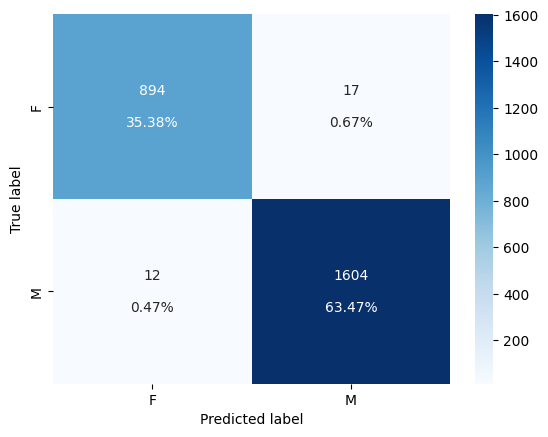

            accuracy precision sensitivity specificity f1-score  support
F              0.989     0.987       0.981       0.993    0.984  911.000
M              0.989     0.990       0.993       0.981    0.991 1616.000
                                                                        
accuracy       0.989                                                    
precision      0.987                                                    
sensitivity    0.981                                                    
specificity    0.993                                                    
fscore         0.984                                                    


In [13]:
KNN_keras = KNeighborsClassifier(n_neighbors=5)
KNN_keras.fit(x_train, y_train)

y_pred_train = KNN_keras.predict(x_train)
y_pred_test = KNN_keras.predict(x_test)

plot_confusion_matrix(y_train, y_pred_train)
print_summary(y_train, y_pred_train)

plot_confusion_matrix(y_test, y_pred_test)
print_summary(y_test, y_pred_test)


 Na podstawie wykresu widać, że potrzeba co najmniej 3 sąsiadów, aby uzyskać
 zadowalające wyniki. Zwiększanie liczby sąsiadów zmniejsza dokładność.
 Jeżeli korzystamy z PCA zwiększanie liczby sąsiadów nie ma większego wpływu.

<AxesSubplot: >

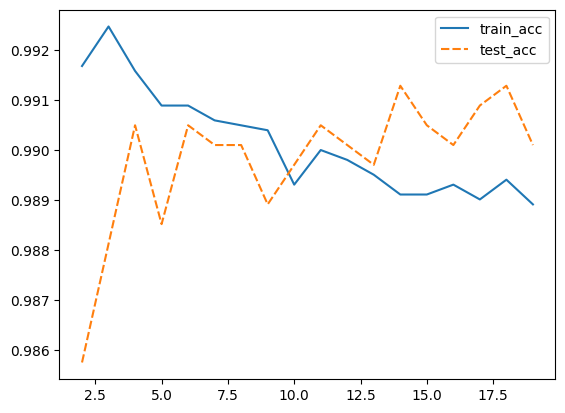

In [14]:
data = pd.DataFrame(columns=["train_acc", "test_acc"], dtype='float')

for i in range(2,20):
  KNN_keras = KNeighborsClassifier(n_neighbors=i)
  KNN_keras.fit(x_train, y_train)

  y_pred_train = KNN_keras.predict(x_train)
  y_pred_test = KNN_keras.predict(x_test)

  data.loc[i] = [
    accuracy_score(y_train, y_pred_train, True),
    accuracy_score(y_test, y_pred_test, True)
  ]

sns.lineplot(data=data)

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Klasyfikacja za pomocą PNN

 Probabilistyczne sieci neuronowe wykorzystują rozkład gęstości i prawdopodobieństwo
 w celu przypisania próbki do odpowiedniej klasy.

In [ ]:
pnn = PNN()
pnn.fit(x_train, y_train)
y_pred = pnn.predict(x_test)

plot_confusion_matrix(y_test, y_pred)
print_summary(y_test, y_pred)

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Klasyfikacja za pomocą drzew decyzyjnych

 Drzewa decyzyjne opierają swoje działanie na prostych warunkach logicznych.
 Wartości parametrów każdej próbki są sprawdzane, czy mieszczą się w odpowiednich
 przedziałach i na tej podstawie wybierana jest klasa.

<AxesSubplot: >

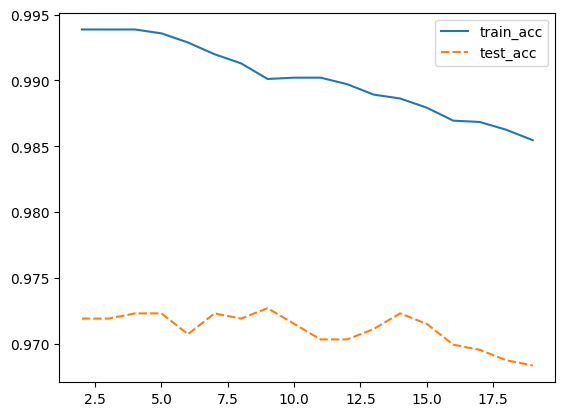

In [15]:
data = pd.DataFrame(columns=["train_acc", "test_acc"])

for i in range(2,20):
  tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=i)
  tree.fit(x_train, y_train)

  y_pred_train = tree.predict(x_train)
  y_pred_test = tree.predict(x_test)

  data.loc[i] = [
    accuracy_score(y_train, y_pred_train, True),
    accuracy_score(y_test, y_pred_test, True)
  ]

sns.lineplot(data=data)


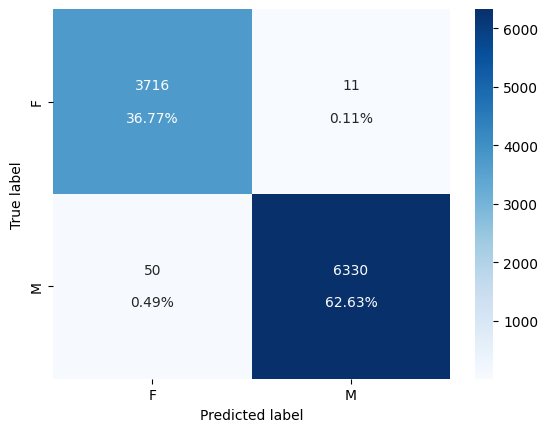

            accuracy precision sensitivity specificity f1-score  support
F              0.994     0.987       0.997       0.992    0.992 3727.000
M              0.994     0.998       0.992       0.997    0.995 6380.000
                                                                        
accuracy       0.994                                                    
precision      0.987                                                    
sensitivity    0.997                                                    
specificity    0.992                                                    
fscore         0.992                                                    


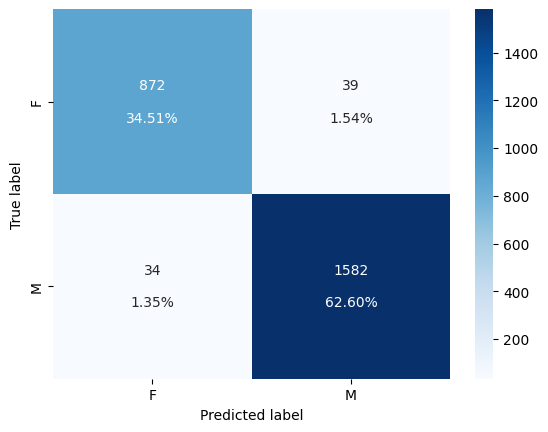

            accuracy precision sensitivity specificity f1-score  support
F              0.971     0.962       0.957       0.979    0.960  911.000
M              0.971     0.976       0.979       0.957    0.977 1616.000
                                                                        
accuracy       0.971                                                    
precision      0.962                                                    
sensitivity    0.957                                                    
specificity    0.979                                                    
fscore         0.960                                                    


In [16]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2)
tree.fit(x_train, y_train)

y_pred_train = tree.predict(x_train)
y_pred_test = tree.predict(x_test)

plot_confusion_matrix(y_train, y_pred_train)
print_summary(y_train, y_pred_train)

plot_confusion_matrix(y_test, y_pred_test)
print_summary(y_test, y_pred_test)

# plot_tree(tree)

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Istotność cech

 Nie każda cecha w równym stopniu przykłada się do zwiększenia jakości modelu.
 Wybranie najistotniejszych cech pozwoli nam zmniejszyć ilość wymiarów przy
 jednoczesnym zachowaniu wysokiej sprawności modelu.

 Problem ten można rozwiązać przy pomocy PCA jednak tracimy informacje
 o poszczególnych cechach.

 Poniżej znajduje się kilka algorytmów, które służą do wybrania najistotniejszych
 cech. W scikit-learn implementacja drzew decyzyjnych ma zmienną feature_importances_
 dzięki czemu "za darmo" możemy dostać potrzebne informacje.

 Drugi sposób polega na permutacji cechy. Mieszamy w ten sposób dane przez co
 dana cecha staje się bezużyteczna. Na wcześniej wytrenowanym modelu sprawdzamy
 jak bardzo miało to wpływ na dokładność.

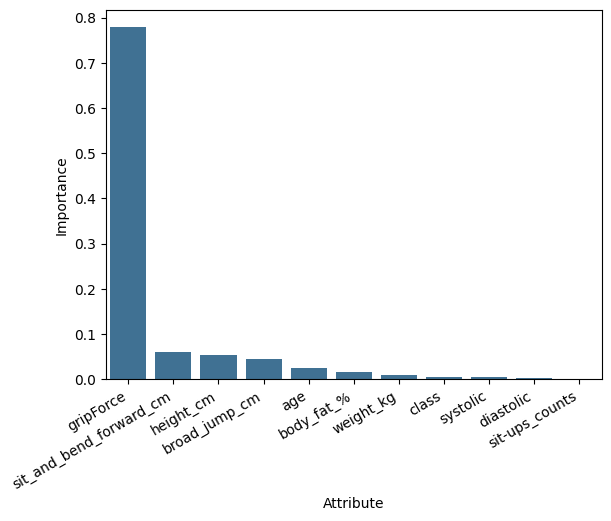

In [17]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2)
tree.fit(x_train, y_train)

plot_importance(x.columns, tree.feature_importances_)


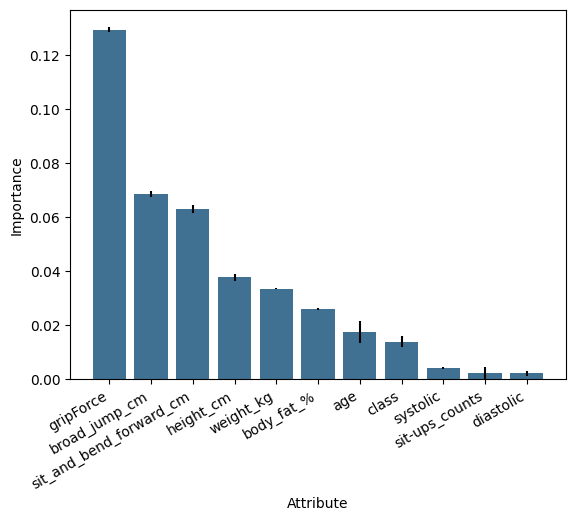

In [18]:
results = permutation_importance(tree, x_train, y_train, scoring='accuracy')
importance = results.importances_mean

plot_importance(x.columns, importance, results.importances_std)


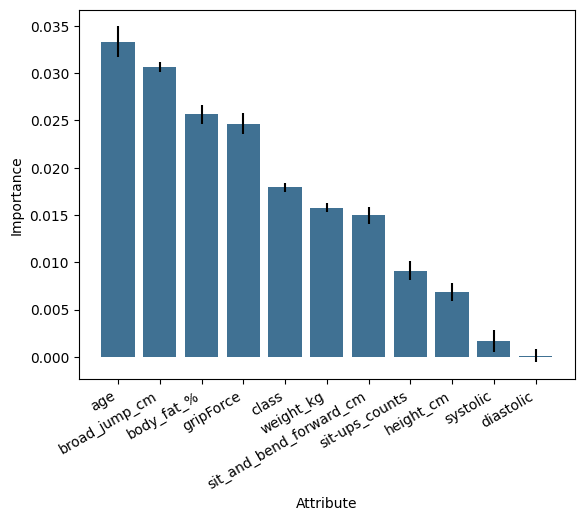

In [19]:
KNN_keras = KNeighborsClassifier(n_neighbors=5)
KNN_keras.fit(x_train, y_train)
results = permutation_importance(KNN_keras, x_train, y_train, scoring='accuracy')
importance = results.importances_mean

plot_importance(x.columns, importance, results.importances_std)


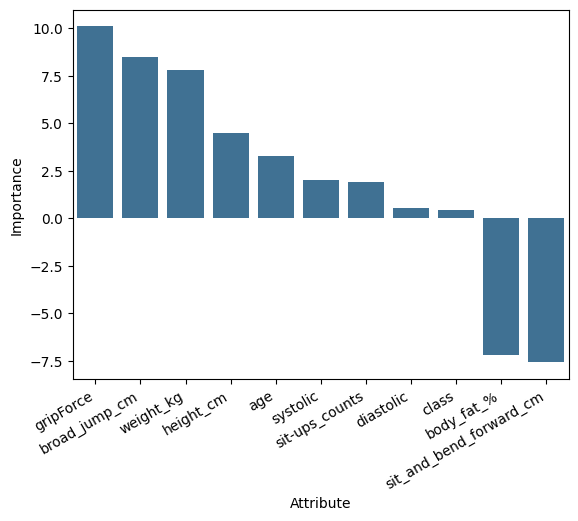

In [20]:
model = LogisticRegression()
model.fit(x_train, y_train)

plot_importance(x.columns, model.coef_[0])


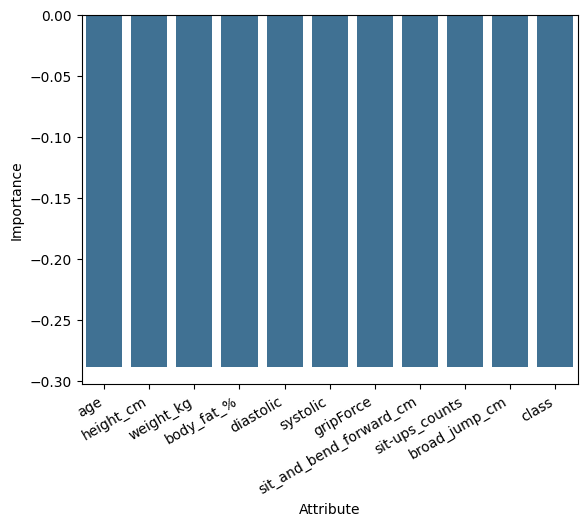

In [21]:
model = LinearRegression()
model.fit(x_train, y_train.map({'M': 0, 'F': 1}))

plot_importance(x.columns, model.coef_[0])

# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////
# //////////////////////////////////////////////////////////////////////////////


 #### Logika rozmyta

 Metoda ta polega na rozmyciu wartości za pomocą funkcji przynależności, które
 ustala ekspert. Następnie na podstawie wartości rozmytych przeprowadzamy
 wnioskowanie wykorzystując sNormy i tNormy.

In [22]:
short = trapezeR(0.3, 0.6)
tall = trapezeL(0.3, .6)

light = trapezeR(0.3, 0.6)
heavy = trapezeL(0.3, .6)

weak = trapezeR(0.3, 0.6)
strong = trapezeL(0.3, .6)

jump_low = trapezeR(0.3, 0.6)
jump_high = trapezeL(0.3, .6)


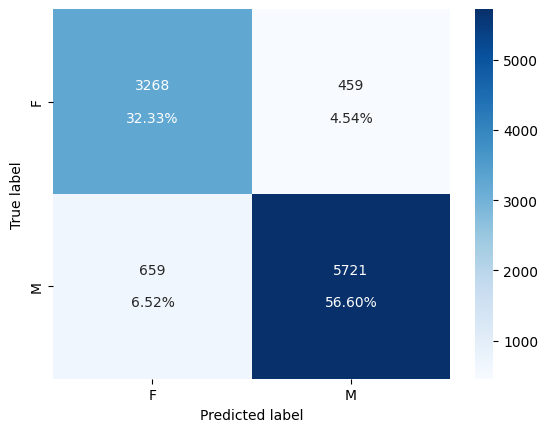

            accuracy precision sensitivity specificity f1-score  support
F              0.889     0.832       0.877       0.897    0.854 3727.000
M              0.889     0.926       0.897       0.877    0.911 6380.000
                                                                        
accuracy       0.889                                                    
precision      0.832                                                    
sensitivity    0.877                                                    
specificity    0.897                                                    
fscore         0.854                                                    


In [23]:
y_pred_train = []

for i, sample in x_train.iterrows():
  m = tall(sample.height_cm) + heavy(sample.weight_kg) + strong(sample.gripForce) + jump_low(sample.broad_jump_cm)
  f = short(sample.height_cm) + light(sample.weight_kg) + weak(sample.gripForce) + jump_high(sample.broad_jump_cm)

  if m > f:
    y_pred_train.append("M")
  else:
    y_pred_train.append("F")

plot_confusion_matrix(y_train, y_pred_train)
print_summary(y_train, y_pred_train)


 Rules\
 short AND weak AND jump_low => F\
 short AND weak AND jump_high => F\
 short AND strong AND jump_low => F\
 short AND strong AND jump_high => M\
 tall AND weak AND jump_low => F\
 tall AND weak AND jump_high => M\
 tall AND strong AND jump_low => M\
 tall AND strong AND jump_high => M\

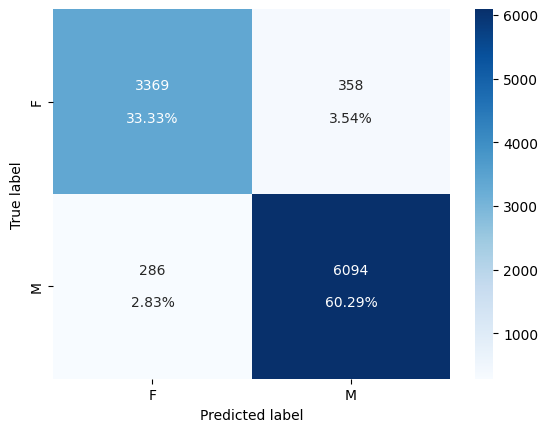

            accuracy precision sensitivity specificity f1-score  support
F              0.936     0.922       0.904       0.955    0.913 3727.000
M              0.936     0.945       0.955       0.904    0.950 6380.000
                                                                        
accuracy       0.936                                                    
precision      0.922                                                    
sensitivity    0.904                                                    
specificity    0.955                                                    
fscore         0.913                                                    


In [24]:
y_pred_train = []

for i, sample in x_train.iterrows():
  f = sNorm([
    tNorm([short(sample.height_cm), weak(sample.gripForce), jump_low(sample.broad_jump_cm)]),
    tNorm([short(sample.height_cm), weak(sample.gripForce), jump_high(sample.broad_jump_cm)]),
    tNorm([short(sample.height_cm), strong(sample.gripForce), jump_low(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), weak(sample.gripForce), jump_low(sample.broad_jump_cm)]),
  ])

  m = sNorm([
    tNorm([short(sample.height_cm), strong(sample.gripForce), jump_high(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), weak(sample.gripForce), jump_high(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), strong(sample.gripForce), jump_low(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), strong(sample.gripForce), jump_high(sample.broad_jump_cm)]),
  ])

  if m > f:
    y_pred_train.append("M")
  else:
    y_pred_train.append("F")

plot_confusion_matrix(y_train, y_pred_train)
print_summary(y_train, y_pred_train)


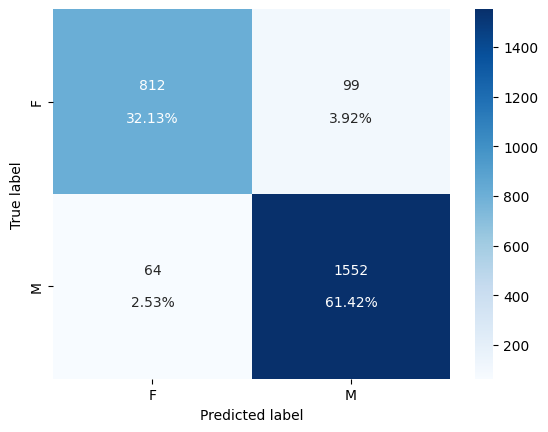

            accuracy precision sensitivity specificity f1-score  support
F              0.935     0.927       0.891       0.960    0.909  911.000
M              0.935     0.940       0.960       0.891    0.950 1616.000
                                                                        
accuracy       0.935                                                    
precision      0.927                                                    
sensitivity    0.891                                                    
specificity    0.960                                                    
fscore         0.909                                                    


In [25]:
y_pred_test = []

for i, sample in x_test.iterrows():
  f = sNorm([
    tNorm([short(sample.height_cm), weak(sample.gripForce), jump_low(sample.broad_jump_cm)]),
    tNorm([short(sample.height_cm), weak(sample.gripForce), jump_high(sample.broad_jump_cm)]),
    tNorm([short(sample.height_cm), strong(sample.gripForce), jump_low(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), weak(sample.gripForce), jump_low(sample.broad_jump_cm)]),
  ])

  m = sNorm([
    tNorm([short(sample.height_cm), strong(sample.gripForce), jump_high(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), weak(sample.gripForce), jump_high(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), strong(sample.gripForce), jump_low(sample.broad_jump_cm)]),
    tNorm([tall(sample.height_cm), strong(sample.gripForce), jump_high(sample.broad_jump_cm)]),
  ])

  if m > f:
    y_pred_test.append("M")
  else:
    y_pred_test.append("F")

plot_confusion_matrix(y_test, y_pred_test)
print_summary(y_test, y_pred_test)